# Treinamento de Modelo de Machine Learning usando AWS SageMaker

### Membros
* 2315530 - Clairton Carneiro Luz

## 1. Introdução

Este documento apresenta um guia para o treinamento de um modelo de Machine Learning utilizando o AWS SageMaker. O objetivo desta atividade é permitir a prática na implementação de um pipeline de aprendizado de máquina, desde a preparação do ambiente até a implantação do modelo treinado.


## 2. Objetivo

O objetivo desta atividade é desenvolver habilidades na utilização do AWS SageMaker para treinar e implantar modelos de Machine Learning. O processo envolve a criação de um ambiente adequado, manipulação de dados, treinamento do modelo, avaliação de desempenho e implantação para uso em produção.

## 3. Preparação do Ambiente:

   ### 3.1 Criar um notebook instance no SageMaker.

* Acesse o console AWS e vá para o serviço `Amazon SageMaker AI`.

* No painel esquerdo, clique em `Notebooks`.
* Clique em `Create notebook instance`.
* Defina um nome para a instância e escolha um tipo adequado, como ml.t3.medium.
* Em IAM role, selecione Create a new role, permitindo acesso ao Amazon S3.
* Clique em Create notebook instance e aguarde até que o status mude para InService.

### 3.2 Configurar as permissões IAM para permitir o acesso ao S3 e SageMaker.

* No console AWS, vá para o serviço IAM.

* Clique em Roles e selecione a função atribuída ao notebook SageMaker.
* Em Permissões, adicione as políticas AmazonS3FullAccess e AmazonSageMakerFullAccess.
* Salve as alterações para garantir que o SageMaker possa acessar os recursos necessários.

### 3.3 Instalar as bibliotecas necessárias.

* Após iniciar o notebook, execute o seguinte comando para instalar as bibliotecas necessárias:

In [15]:
%pip install -q -U boto3 sagemaker pandas numpy scikit-learn kagglehub matplotlib seaborn


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 4. Download e Preparação dos Dados:

### 4.1 Download dataset

In [1]:

import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("eslamelsolya/laptop-price-prediction")

print("Path to dataset files:", path)
df_original = pd.read_csv(path + "/laptop_data.csv", index_col=0)

df = df_original.copy()
df_original.head()

/Users/clairtonluz/projects/personal/MBA-em-ciencia-de-dados/SageMaker/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/clairtonluz/.cache/kagglehub/datasets/eslamelsolya/laptop-price-prediction/versions/1


,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


### 4.2 Realizar a limpeza e pré-processamento dos dados (tratamento de valores faltantes, normalização, etc.).

In [3]:
df.shape

(1303, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


In [5]:
print(df.duplicated().sum())
df.drop_duplicates(inplace = True)
df.duplicated().sum()

29


0

In [6]:
df.groupby("Company")["TypeName"].value_counts()

Company    TypeName          
Acer       Notebook               76
           2 in 1 Convertible      8
           Gaming                  8
           Netbook                 5
           Ultrabook               4
Apple      Ultrabook              21
Asus       Notebook               62
           Gaming                 54
           Ultrabook              18
           2 in 1 Convertible     13
           Netbook                 4
Chuwi      Notebook                3
Dell       Notebook              159
           Ultrabook              49
           Gaming                 40
           2 in 1 Convertible     30
           Workstation            11
           Netbook                 2
Fujitsu    Notebook                3
Google     Ultrabook               3
HP         Notebook              180
           Ultrabook              36
           2 in 1 Convertible     19
           Workstation            14
           Gaming                 12
           Netbook                 7
Huawei  

In [7]:
df.isna().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

In [8]:
# Removendo unidades de medida e convertendo para float
print(df["Weight"].values)
df["Weight"] = df["Weight"].str.replace("kg", "")
df["Weight"] = df["Weight"].astype(float)

['1.37kg' '1.34kg' '1.86kg' ... '1.3kg' '1.5kg' '2.19kg']


In [9]:
# removendo unidades de medida e convertendo para float
print(df["Ram"].values)
df["Ram"] = df["Ram"].str.replace("GB", "")
df["Ram"] = df["Ram"].astype(float)

['8GB' '8GB' '8GB' ... '16GB' '2GB' '6GB']


In [10]:
from sklearn.preprocessing import LabelEncoder
# Convertendo colunas categoricas para numericas
label_encoder = LabelEncoder()
for col in df.select_dtypes(include = ["object"]).columns:
  df[col] = label_encoder.fit_transform(df[col])

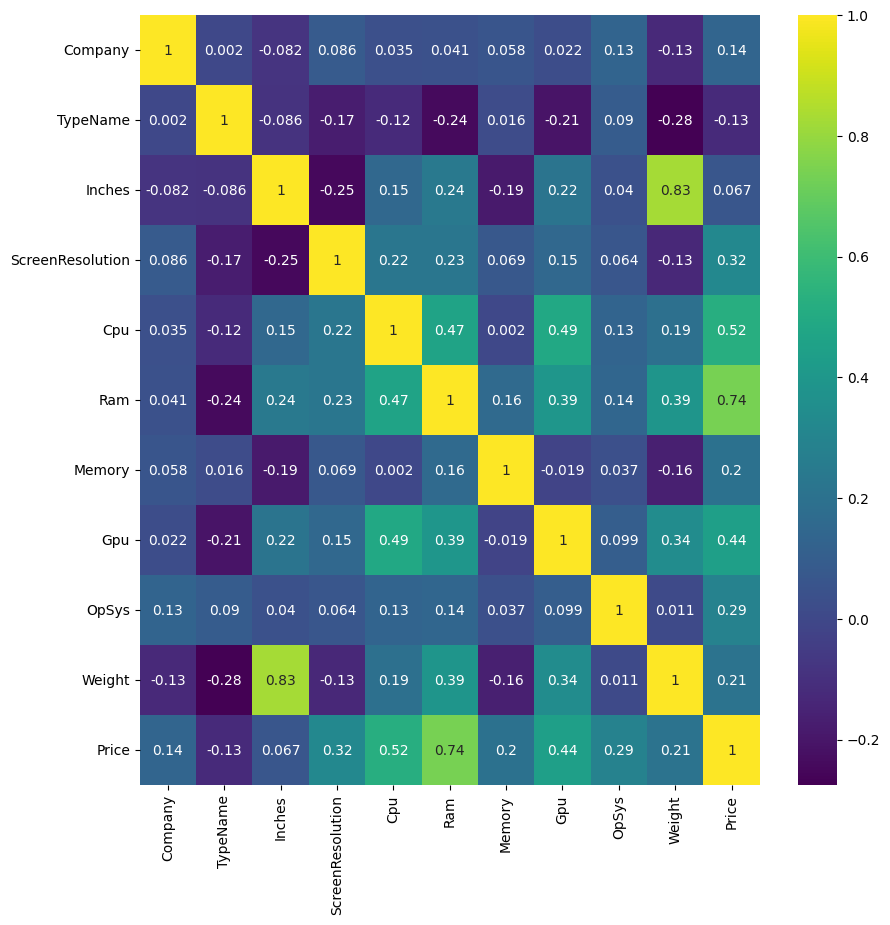

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), annot = True, fmt = ".2g", cmap = "viridis")
plt.show()

## 5 Dividir o dataset em conjuntos de treino e teste.

### 5.1 Separando features e target

In [11]:
import numpy as np

X = df.drop("Price", axis = 1)
y = np.log(df["Price"] + 1e-8)

### 5.2 Separando treino, teste e validação

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

### 5.3 Transformando valores para ficar no mesmo padrão de escala.

In [18]:
from sklearn.preprocessing import StandardScaler

Scaling_Features = StandardScaler()
X_train = Scaling_Features.fit_transform(X_train)
X_test = Scaling_Features.transform(X_test)
X_val = Scaling_Features.transform(X_val)

## 6. Armazenamento dos Dados no S3:

### 6.1 Criar um bucket S3.

* No console AWS, vá para o serviço S3.

* Clique em Create bucket e defina um nome único.

* Configure permissões adequadas e finalize a criação.

### 6.2 Upload dos dados de treino e teste para o bucket S3.

In [ ]:
# Salvando os dados de treino, teste e validação no s3
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "laptop-price-prediction"

X_train_key = "train/train.csv"
X_test_key = "test/test.csv"
X_val_key = "val/val.csv"

pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)], axis = 1).to_csv("train.csv", header = False, index = False)
pd.concat([pd.DataFrame(y_test), pd.DataFrame(X_test)], axis = 1).to_csv("test.csv", header = False, index = False)
pd.concat([pd.DataFrame(y_val), pd.DataFrame(X_val)], axis = 1).to_csv("val.csv", header = False, index = False)

boto3.Session().resource("s3").Bucket(bucket).Object(prefix + "/" + X_train_key).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(prefix + "/" + X_test_key).upload_file("test.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(prefix + "/" + X_val_key).upload_file("val.csv")


## 7. Treinamento do Modelo:

### 7.1 Escolher um algoritmo de machine learning disponível no SageMaker (por exemplo, XGBoost).

In [ ]:
from sagemaker.sklearn.estimator import SKLearn

### 7.2 Configurar o job de treinamento no SageMaker.

In [ ]:
sklearn = SKLearn(
    entry_point = "train.py",
    role = sagemaker.get_execution_role(),
    instance_type = "ml.m5.large",
    sagemaker_session = sagemaker_session,
    hyperparameters = {
        "max_depth": 5,
        "n_estimators": 100,
        "learning_rate": 0.1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse"
    }
)

### 7.3 Iniciar o treinamento do modelo utilizando os dados armazenados no S3.

In [ ]:

# Treinando o modelo
sklearn.fit({
    "train": "s3://" + bucket + "/" + prefix + "/" + X_train_key,
    "test": "s3://" + bucket + "/" + prefix + "/" + X_test_key,
    "val": "s3://" + bucket + "/" + prefix + "/" + X_val_key
})


## 8. Avaliação do Modelo:

### 8.1 Realizar previsões utilizando o conjunto de teste.

### 8.2 Avaliar o desempenho do modelo utilizando métricas apropriadas (acurácia, precisão, recall, F1-score).

### 8.3 Gerar um relatório de avaliação.

In [ ]:
# Deploy do modelo
predictor = sklearn.deploy(
    initial_instance_count = 1,
    instance_type = "ml.t2.medium"
)

# Testando o modelo
y_pred = predictor.predict(X_test)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

# Deletando o endpoint

predictor.delete_endpoint()


# Salvando o modelo
model_path = sklearn.model_data
model_path

boto3.Session().resource("s3").Bucket(bucket).download_file(model_path, "model.tar.gz")

## 9. Implantação do Modelo:

### 9.1 Implantar o modelo treinado como um endpoint no SageMaker.

In [ ]:
# Deploy do modelo
predictor = sklearn.deploy(
    initial_instance_count = 1,
    instance_type = "ml.t2.medium"
)

### 9.2 Testar o endpoint realizando previsões em tempo real.

In [ ]:
# validando o modelo
y_pred = predictor.predict(X_val)

mean_squared_error(y_val, y_pred)

### 9.3 Removendo endpoint

In [ ]:
# Deletando o endpoint
predictor.delete_endpoint()